                 Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0  Logistic Regression  0.730594  0.730817   0.708333  0.779817  0.742358   
1        Decision Tree  0.835616  0.835822   0.806723  0.880734  0.842105   
2                  KNN  0.945205  0.945288   0.929204  0.963303  0.945946   
3          Naive Bayes  0.575342  0.573520   0.863636  0.174312  0.290076   
4        Random Forest  0.940639  0.940534   0.961538  0.917431  0.938967   
5              XGBoost  0.940639  0.940701   0.928571  0.954128  0.941176   

        MCC  
0  0.463767  
1  0.674178  
2  0.891021  
3  0.244567  
4  0.882172  
5  0.881622  


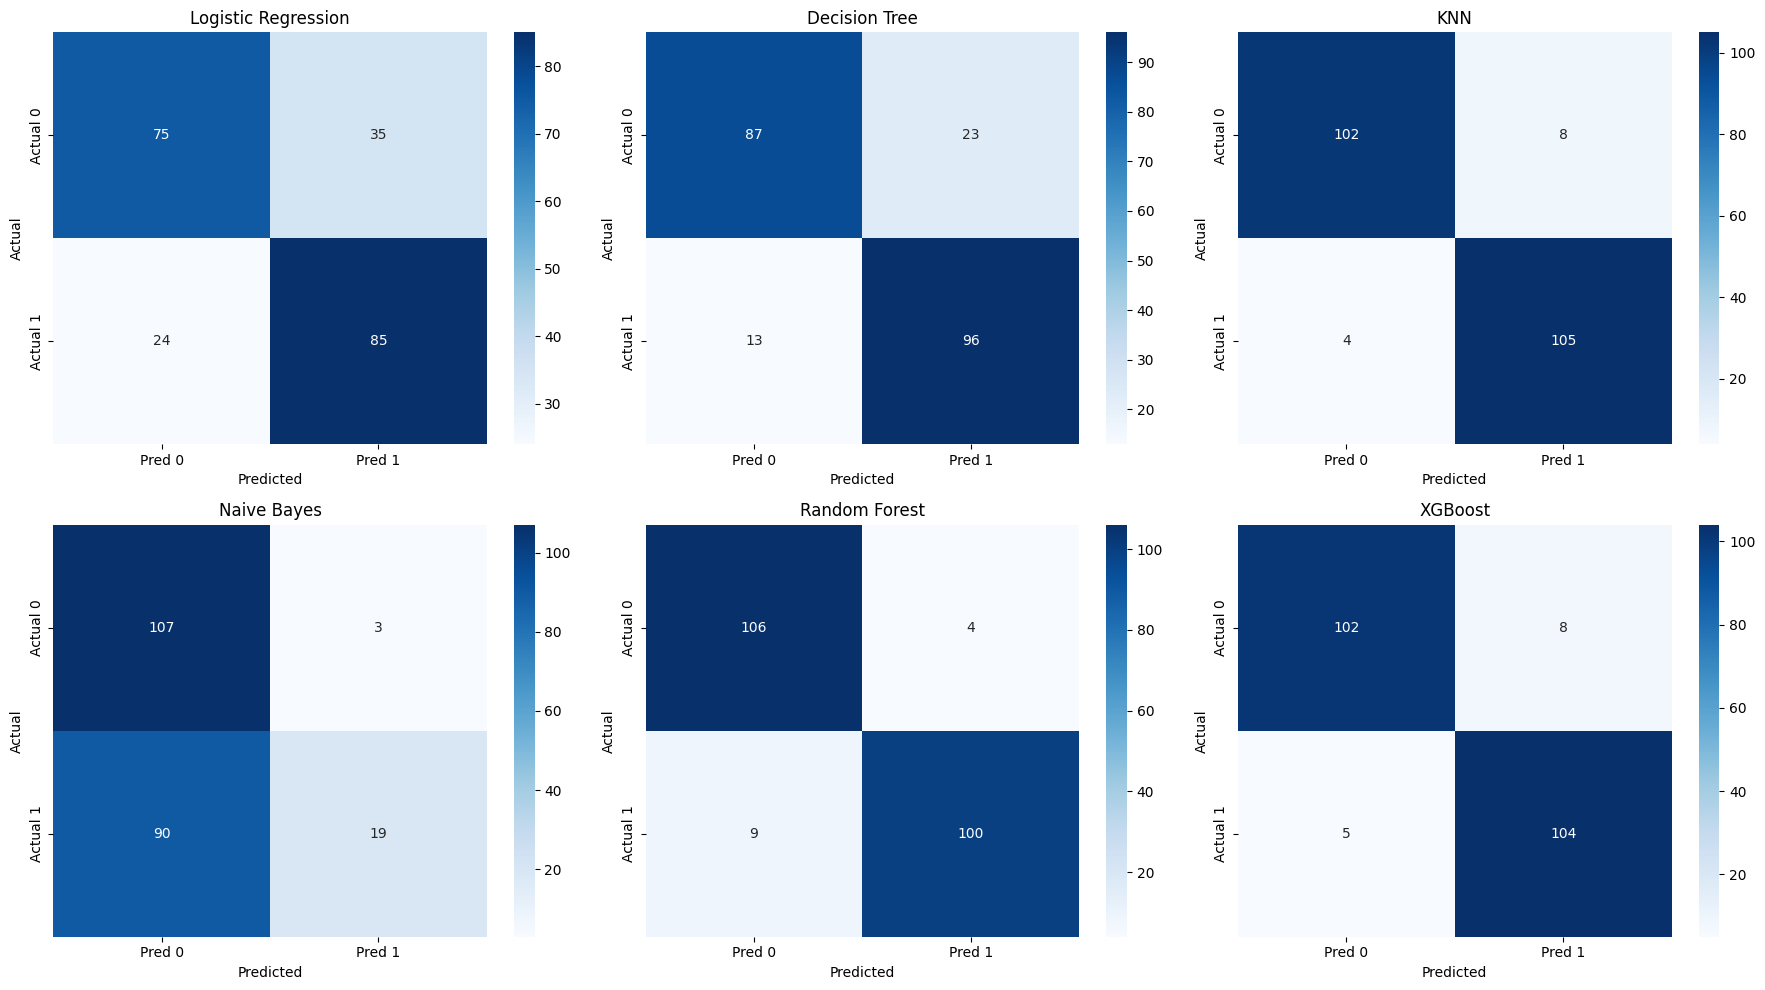

In [1]:
# IMPORT LIBRARIES
# ===============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix
)

import warnings
warnings.filterwarnings("ignore")

# ===============================
# LOAD DATA
# ===============================
df = pd.read_csv("/home/cloud/Downloads/raw_merged_heart_dataset.csv")

# CATEGORICAL COLUMNS
categorical_columns = ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']

# LABEL ENCODE CATEGORICAL COLUMNS
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# DATA CLEANING
df.replace("?", np.nan, inplace=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(df.median(), inplace=True)

# ADDITIONAL ENCODING
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# FEATURES AND TARGET
X = df.drop('target', axis=1)
y = df['target']

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# FEATURE SCALING (for KNN and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create directory 
if not os.path.exists("model"):
    os.makedirs("model")

models = []
predictions = {}

# 1. Logistic Regression
logreg_params = {
    "C": [0.005],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}
logreg = GridSearchCV(LogisticRegression(max_iter=1000),
                      logreg_params,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)
logreg.fit(X_train_scaled, y_train)
best_logreg = logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_scaled)
joblib.dump(best_logreg, "model/logistic_regression_model.pkl")
models.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'AUC': roc_auc_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg),
    'Recall': recall_score(y_test, y_pred_logreg),
    'F1 Score': f1_score(y_test, y_pred_logreg),
    'MCC': matthews_corrcoef(y_test, y_pred_logreg)
})
predictions['Logistic Regression'] = y_pred_logreg

# 2. Decision Tree
dtree_params = {
    "max_depth": [13],
    "min_samples_split": [200],
    "min_samples_leaf": [4]
}
dtree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                     dtree_params,
                     cv=5,
                     scoring='accuracy',
                     n_jobs=-1)
dtree.fit(X_train, y_train)
best_dtree = dtree.best_estimator_
y_pred_dtree = best_dtree.predict(X_test)
joblib.dump(best_dtree, "model/decision_tree_model.pkl")
models.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_pred_dtree),
    'AUC': roc_auc_score(y_test, y_pred_dtree),
    'Precision': precision_score(y_test, y_pred_dtree),
    'Recall': recall_score(y_test, y_pred_dtree),
    'F1 Score': f1_score(y_test, y_pred_dtree),
    'MCC': matthews_corrcoef(y_test, y_pred_dtree)
})
predictions['Decision Tree'] = y_pred_dtree

# 3. KNN
knn_params = {
    "n_neighbors": [5],
    "weights": ["uniform", "distance"],
    "p": [2]
}
knn = GridSearchCV(KNeighborsClassifier(),
                   knn_params,
                   cv=5,
                   scoring='accuracy',
                   n_jobs=-1)
knn.fit(X_train_scaled, y_train)
best_knn = knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
joblib.dump(best_knn, "model/knn_model.pkl")
models.append({
    'Model': 'KNN',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'AUC': roc_auc_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1 Score': f1_score(y_test, y_pred_knn),
    'MCC': matthews_corrcoef(y_test, y_pred_knn)
})
predictions['KNN'] = y_pred_knn

# 4. Naive Bayes
nb = GaussianNB() 
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test_scaled)
joblib.dump(nb, "model/naive_bayes_model.pkl")
models.append({
    'Model': 'Naive Bayes',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'AUC': roc_auc_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb),
    'F1 Score': f1_score(y_test, y_pred_nb),
    'MCC': matthews_corrcoef(y_test, y_pred_nb)
})
predictions['Naive Bayes'] = y_pred_nb

# 5. Random Forest
rf_params = {
    "n_estimators": [200],
    "max_depth": [11],
    "min_samples_split": [10]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42),
                  rf_params,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1)
rf.fit(X_train, y_train)
best_rf = rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
joblib.dump(best_rf, "model/random_forest_model.pkl")
models.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'AUC': roc_auc_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'MCC': matthews_corrcoef(y_test, y_pred_rf)
})
predictions['Random Forest'] = y_pred_rf

# 6. XGBoost
xgb_params = {
    "n_estimators": [100],
    "max_depth": [7],
    "learning_rate": [0.1]
}
xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
                         xgb_params,
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1)
xgb_model.fit(X_train, y_train)
best_xgb = xgb_model.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
joblib.dump(best_xgb, "model/xgboost_model.pkl")
models.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'AUC': roc_auc_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'MCC': matthews_corrcoef(y_test, y_pred_xgb)
})
predictions['XGBoost'] = y_pred_xgb

# ===============================
# Display metrics DataFrame
# ===============================
metrics_df = pd.DataFrame(models)
print(metrics_df)

# ===============================
# Plot confusion matrices 
# ===============================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["Actual 0", "Actual 1"],
                ax=axes[i])

    axes[i].set_title(model_name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()
